In [6]:
import os

from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import xml.etree.ElementTree as ET

import torch
from torch.utils.data import Dataset
from torchvision.transforms import Compose, Grayscale, ToTensor


class Manga109Dataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.samples = self._load_samples()
        self.base_transform = Compose([Grayscale(), ToTensor()]) # Simplified to include ToTensor

    def __getitem__(self, idx):
        image_path, bboxes = self.samples[idx]
        image = self.base_transform(Image.open(image_path)) # Apply transformations
        bbox_tensor = torch.tensor(bboxes, dtype=torch.float32)  # Convert bboxes to tensor

        return image, bbox_tensor

    def __len__(self):
        return len(self.samples)

    def _load_samples(self):
        samples = []
        annotations_dir = os.path.join(self.root_dir, 'annotations')
        images_dir = os.path.join(self.root_dir, 'images')

        for annotation_file in os.listdir(annotations_dir):
            tree = ET.parse(os.path.join(annotations_dir, annotation_file))
            root = tree.getroot()
            book_title = root.get('title')

            for page in root.findall('.//page'):
                page_index = page.get('index')
                image_path = os.path.join(images_dir, book_title, f'{int(page_index):03}.jpg')
                bboxes = []

                for frame in page.findall('frame'):
                    bbox = [
                        float(frame.get('xmin')),
                        float(frame.get('ymin')),
                        float(frame.get('xmax')),
                        float(frame.get('ymax'))
                    ]
                    bboxes.append(bbox)

                samples.append((image_path, bboxes))

        return samples

    def load_manga_page(self, manga_title, page_index):
        xml_path = os.path.join(self.root_dir, 'annotations', f'{manga_title}.xml')
        image_path = os.path.join(self.root_dir, 'images', manga_title, f'{page_index:03}.jpg')

        if not os.path.exists(xml_path) or not os.path.exists(image_path):
            raise FileNotFoundError("The specified manga title or page index does not exist.")

        image = Image.open(image_path)
        image = image.convert('RGB')  # For better visual representation in plot

        tree = ET.parse(xml_path)
        root = tree.getroot()
        elements = {'frame': [], 'text': [], 'face': [], 'body': []}

        page = root.find(f".//page[@index='{page_index}']")
        if page is None:
            raise ValueError("Page not found in the XML file.")

        for element in page:
            element_type = element.tag
            if element_type in elements:
                bbox = [
                    int(element.get('xmin')),
                    int(element.get('ymin')),
                    int(element.get('xmax')),
                    int(element.get('ymax'))
                ]
                elements[element_type].append(bbox)

        fig, ax = plt.subplots()
        ax.imshow(image)

        colors = {'frame': 'red', 'text': 'blue', 'face': 'green', 'body': 'yellow'}
        for element_type, bboxes in elements.items():
            for bbox in bboxes:
                rect = patches.Rectangle(
                    (bbox[0], bbox[1]),  # xmin, ymin
                    bbox[2] - bbox[0],  # width (xmax - xmin)
                    bbox[3] - bbox[1],  # height (ymax - ymin)
                    linewidth=1,
                    edgecolor=colors[element_type],
                    facecolor='none'
                )
                ax.add_patch(rect)

        plt.show()

        return image, elements


In [7]:
from torch.utils.data import DataLoader, random_split

root_dir = 'manga109'

dataset = Manga109Dataset(root_dir) # Create the dataset
train_size = int(0.8 * len(dataset))  # 80% of the dataset for training
val_size = len(dataset) - train_size  # Remaining 20% for validation

# Randomly split the dataset into training and validation datasets
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,       # shuffle training data to improve learning
    num_workers=2,      # Adjust to system's specifications
    pin_memory=True     # Recommended if using a GPU to speed up data transfer
)

val_loader = DataLoader(
    val_dataset,
    batch_size=64,
    shuffle=False,      # No need to shuffle validation data
    num_workers=2,
    pin_memory=True
)

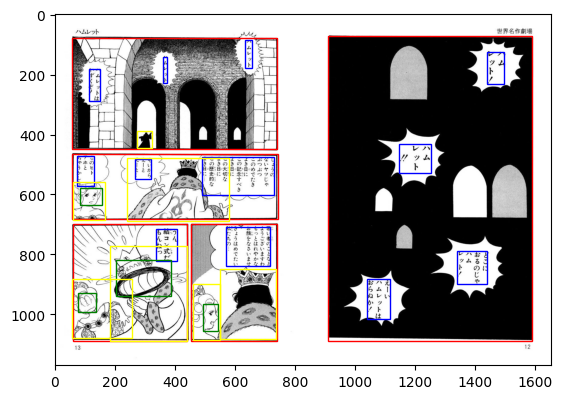

In [8]:
image, annotations = dataset.load_manga_page('Hamlet', 6)